In [ ]:
import jax.numpy as np
import jax
from jax import grad, jacfwd, hessian, jacrev
from jax import vmap
from jax import jit
from jax import random
from jax.lax import cond 
import numpy
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

In [ ]:
def x_t(t):
    return numpy.float64(0.000002195590737) * numpy.exp(numpy.sqrt(3)*t) * (1.0 + 2.0/3.0 * numpy.sqrt(3)) + numpy.float64(
        -73.0722486) * numpy.exp(-numpy.sqrt(3)*t)* (1.0 - 2.0/3.0 * numpy.sqrt(3))
    #return numpy.float64(numpy.float64(0.0000047308405566675191562)*numpy.exp(1.7320508075688772935*t, dtype=numpy.float64)+
    #3.3965907005033986468e-7 * numpy.exp(17.320508075688772935 - 1.7320508075688772935*t, dtype=numpy.float64))
    #return 0.0000041*np.exp(15.588-1.7321*t)*(6.4641*np.exp(3.4641*t - 17.3205)+0.4641)
    #return -0.470519*np.exp(1.5 *t)*(-0.373020*np.cos(0.866025*t)-0.927823*np.sin(0.866025*t))

def L_t(t):
    return numpy.float64(0.000002195590737) * numpy.exp(numpy.sqrt(3)*t) + numpy.float64(
        -73.0722486) * numpy.exp(-numpy.sqrt(3)*t)
    #return numpy.float64(0.0000021955907433085896458*numpy.exp(1.7320508075688772935*t, dtype=numpy.float64)
    #-0.0000021955907433085896458 * numpy.exp(17.320508075688772935 - 1.7320508075688772935*t, dtype=numpy.float64))
    #return 0.0000124*np.exp(15.588-1.7321*t)*(6.4641*np.exp(3.4641*t - 17.3205)-1.)
    #return -0.814962*np.exp(1.5 *t)*(-0.373020*np.sin(0.866025*t)+0.927823*np.cos(0.866025*t))


def exact_sol(t):
    
    return x_t(t), L_t(t)

def exact_deriv(t):
    x = x_t(t)
    L = L_t(t)
    u = (x+L)/2.
    return x+u, -u+2.*x-L

In [ ]:
def nn(params, t, c):
    M0 = c['M0']
    M1 = c['M1']
    M2 = c['M2']
    #t = (t/c['t1'] -0.5)*2.
    t = (t - c['t0'])/(c['t1']- c['t0']) -0.5
    w0 = params[:M0]
    b0 = params[M0:2*M0]
    w1 = np.reshape(params[2*M0: 2*M0 + M0*M1], (M0, M1))
    b1 = params[2*M0 + M0*M1: 2*M0 + M0*M1 + M1]
    w2 = np.reshape(params[2*M0 + M0*M1 + M1 : M2*M1 + 2*M0 + M0*M1 + M1], (M1, M2))
    b2 = params[M2*M1 + 2*M0 + M0*M1 + M1: M2*M1 + 2*M0 + M0*M1 + M1 + M2]
    w3 = np.reshape(params[M2*M1 + 2*M0 + M0*M1 + M1 + M2: M2*M1 + 2*M0 + M0*M1 + M1 + M2 + M2*2], (M2, 2))
    b3 = params[M2*M1 + 2*M0 + M0*M1 + M1 + M2 + M2*2: M2*M1 + 2*M0 + M0*M1 + M1 + M2 + M2*2 + 2]

    w1_2 = params[M2*M1 + 2*M0 + M0*M1 + M1 + M2 + M2*2 + 2: M2*M1 + 2*M0 + M0*M1 + M1 + M2 + M2*2 + 2 + M0] 
    w2_2 = params[M2*M1 + 2*M0 + M0*M1 + M1 + M2 + M2*2 + 2 + M0: M2*M1 + 2*M0 + M0*M1 + M1 + M2 + M2*2 + 2 + M0 + M1]
    w3_2 = params[M2*M1 + 2*M0 + M0*M1 + M1 + M2 + M2*2 + 2 + M0 + M1: M2*M1 + 2*M0 + M0*M1 + M1 + M2 + M2*2 + 2 + M0 + M1 + M2]

    t0 = sigmoid(t*w0 + b0) #+ t
    t1 = sigmoid(np.dot(t0, w1) + b1) #+ np.dot(t0, w1_2)
    t2 = sigmoid(np.dot(t1, w2) + b2) #+ np.dot(t1, w2_2)
    t3 = np.dot(t2, w3) + b3 #+ np.dot(t2, w3_2)

    x1 = c['ics'][0] + (t + 0.5)*t3[0]#c['ics'][0] + t*
    L1 = (t - 0.5)*t3[1]#(np.dot(t0, w2) + b2)#(t - c['t1'])*
    return x1, L1

dNNdt = jacrev(nn, 1)

v_nn = jax.vmap(nn, (None, 0, None))
v_dNNdt = jax.vmap(dNNdt, (None, 0, None), 0)

In [ ]:
def loss(params, t, c):
    dx, dL = v_dNNdt(params, t, c)
    x, L = v_nn(params, t, c)
    #uopt = 1./(2.*L)
    #uopt = 1.0/(2.0*(1.0 - t))
    u = (x + L)*0.5
    res = 0.
    #res += (x - x_t(t))**2 + (L - L_t(t))**2
    res += (dx - (x + u))**2#(dx - (x + u))
    res += (dL - (-u + 2.*x - L))**2#(dL - (u - 2.*x + L))


    #res += (-dx + (1. + uopt) * (1. - uopt)) * (-dx + (1. + uopt) * (1. - uopt))#(-dx +  1. - uopt*uopt) * (-dx +  1. - uopt*uopt)

    #res += (dL + 1.)*(dL + 1.)
    #res = 0.0
    
    #res += (L - (1.0 - t)) * (L - (1.0 - t))
    #res += (x - (-1.0/12.0 *(t-1.0)**3 + t + 11.0/12.0)) * (x - (-1.0/12.0 *(t-1.0)**3 + t + 11.0/12.0))

    return res.mean()

def loss_batched(params, t, c):
    res = []
    for t0 in t:
        res.append(loss(params, t0, c))

    return np.array(res).mean()

def loss_batched2(params, t, c):
    res = []
    for t0 in t:
        res.append(loss(params, t0, c))

    return np.array(res).mean(), np.array(res).max()

dLoss = grad(loss, 0)

In [ ]:
consts = {'M0':4, 'M1': 8, 'M2': 32 , 'ics': [2.], 't0':1., 't1':5.}

In [ ]:
epochs = 100000

learning_rate = 0.1
inputs = np.linspace(consts['t0'], consts['t1'], num=51)
batch_size = 10
key = random.PRNGKey(0)
M0 = consts['M0']
M1 = consts['M1']
M2 = consts['M2']
params = (random.normal(key, shape=(M2*M1 + 2*M0 + M0*M1 + M1 + M2 + M2*2 + 2 + M0 + M1 + M2, )))#*0.1
v = 0.0
m = 0.0
b1 = 0.9
b2 = 0.999
bestLoss = 1000000.0
bestParams = params
ec = 1

In [ ]:
bad_ep = 0
for epoch in range(epochs):
    sample = numpy.random.choice(inputs, size = batch_size)
    rnd = (numpy.random.random(batch_size)-0.5 )*0.1
    #rnd = numpy.clip(rnd, 0., 1.)
    sample += rnd
    sample = numpy.clip(sample, consts['t0'], consts['t1'])
    #assert numpy.array(sample).min() >=0 and numpy.array(sample).max() <= 1.
    #print(sample)
    #learning_rate = learning_rate * 0.999
    if epoch % ec == 0:
      currLoss = loss(params, inputs, consts)
      print('epoch: %3d loss: %.6f lr: %.6f', (epoch, currLoss, learning_rate) )
      if currLoss < bestLoss:
        print('Loss Updated!')
        print(' ')
        bestParams = params
        bestLoss = currLoss
      else:
        bad_ep += 1
        if bad_ep >= 5:
          learning_rate = learning_rate * 0.1
          if learning_rate <= 1e-5:
            break

          bad_ep=0


    gradient = dLoss(params, sample, consts)# + momentum*velocity
    m = b1*m + (1. -b1)* gradient
    v = b2*v + (1.-b2)*(np.square(gradient))
    m0 = m / (1. -b1)
    v0 = v / (1. -b2)
    velocity = - learning_rate*(m0 / (np.sqrt(v0) + 1e-8))
    params += velocity

In [ ]:
bad_ep = 0
step = -1e-4
for epoch in range(epochs):
    sample = numpy.random.choice(inputs, size = batch_size)
    rnd = (numpy.random.random(batch_size)-0.5 )*0.1
    #rnd = numpy.clip(rnd, 0., 1.)
    sample += rnd
    sample = numpy.clip(sample, consts['t0'], consts['t1'])
    #assert numpy.array(sample).min() >=0 and numpy.array(sample).max() <= 1.
    #print(sample)
    #learning_rate = learning_rate * 0.999
    learning_rate = learning_rate + step
    if learning_rate <= 1e-8:
     step= 1e-3
    if learning_rate >= 0.1:
      step = -1e-4
    if epoch % ec == 0:
      currLoss = loss(params, inputs, consts)
      print('epoch: %3d loss: %.6f lr: %.6f', (epoch, currLoss, learning_rate) )
      if currLoss < bestLoss:
        print('Loss Updated!')
        print(' ')
        bestParams = params
        bestLoss = currLoss
      #else:
      #  bad_ep += 1
      #  if bad_ep >= 50:
      #    learning_rate = learning_rate * 0.1
      #    if learning_rate <= 1e-5:
      #      break

       #   bad_ep=0


    gradient = dLoss(params, sample, consts)# + momentum*velocity
    m = b1*m + (1. -b1)* gradient
    v = b2*v + (1.-b2)*(np.square(gradient))
    m0 = m / (1. -b1)
    v0 = v / (1. -b2)
    velocity = - learning_rate*(m0 / (np.sqrt(v0) + 1e-8))
    params += velocity

epoch: %3d loss: %.6f lr: %.6f (0, DeviceArray(38.205097, dtype=float32), 0.0999)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (1, DeviceArray(12.719052, dtype=float32), 0.0998)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (2, DeviceArray(11.786815, dtype=float32), 0.0997)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (3, DeviceArray(13.492784, dtype=float32), 0.0996)
epoch: %3d loss: %.6f lr: %.6f (4, DeviceArray(13.821266, dtype=float32), 0.09949999999999999)
epoch: %3d loss: %.6f lr: %.6f (5, DeviceArray(11.836929, dtype=float32), 0.09939999999999999)
epoch: %3d loss: %.6f lr: %.6f (6, DeviceArray(9.730252, dtype=float32), 0.09929999999999999)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (7, DeviceArray(7.355504, dtype=float32), 0.09919999999999998)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (8, DeviceArray(6.4435616, dtype=float32), 0.09909999999999998)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (9, DeviceArray(7.025703, dtype=float32), 0.09899999999999998)
epoch: %3

KeyboardInterrupt: ignored

In [ ]:
#with open('/content/gdrive/My Drive/weights1.npy', 'wb') as f:
#    np.save(f, bestParams)

In [ ]:
bestParams = np.load('/content/gdrive/My Drive/weights1.npy', allow_pickle=True)

In [ ]:
sol_exact = []
sol = []

deriv = []
deriv_exact = []

inputs2 = np.linspace(consts['t0'], consts['t1'], num=101)
for t in inputs2:
  sol_exact.append(exact_sol(t))
  sol.append(nn(bestParams, t, consts))

  dx, dL = dNNdt(bestParams, t, consts)
  deriv.append((dx, dL))
  deriv_exact.append(exact_deriv(t))




NameError: ignored

In [ ]:
v_nn(bestParams, np.array([5., 1.]), consts)

(DeviceArray([0.01322007, 2.        ], dtype=float32),
 DeviceArray([  0.      , -12.894799], dtype=float32))

In [ ]:
sol_exact[-1]

(0.029251712371431857, -2.5889084279140384e-11)

In [ ]:
sol[-1]

(DeviceArray(0.01322031, dtype=float32), DeviceArray(0., dtype=float32))

In [ ]:
sol_exact = numpy.array(sol_exact)
sol = numpy.array(sol)
deriv = numpy.array(deriv)
deriv_exact = numpy.array(deriv_exact)
sol.shape

(101, 2)

In [ ]:
res = numpy.append(sol_exact, sol,axis=1 )
res2 = numpy.append(deriv_exact, deriv,axis=1)

In [ ]:
#SHOOTING

In [ ]:
def fun(t, y, c):
    x, L = y
    u = (x + L)*0.5
    dx = (x + u)#(dx - (x + u))
    dL = (-u + 2.*x - L)
    
    return numpy.array([dx, dL])

In [ ]:
from scipy.integrate import solve_ivp
from scipy import optimize
def shootin_func(x, c):
    sol = solve_ivp(fun, (c['t0'], c['t1']), [c['ics'][0], x[0]], method='DOP853', args=(c,),atol =1e-8, rtol=1e-8)#DOP853
    if sol.status == -1:
      raise NotImplementedError
      
    return sol.y[1, -1]

In [ ]:
optimize.root(shootin_func, [2.0],method='hybr', args=(consts,),tol=1e-8)

    fjac: array([[-1.]])
     fun: 1.4693662953035869e-12
 message: 'The solution converged.'
    nfev: 5
     qtf: array([-8.07390266e-12])
       r: array([-68.37206473])
  status: 1
 success: True
       x: array([-12.92801797])

In [ ]:
sol_s = solve_ivp(fun, (consts['t0'], consts['t1']), [2.0, -12.92801797], method='DOP853', args=(consts,), t_eval=inputs2,atol =1e-8, rtol=1e-8)

In [ ]:
s = numpy.swapaxes(sol_s.y, 1, 0)

In [ ]:
s.shape

(101, 2)

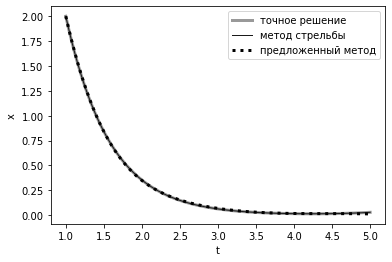

In [ ]:

plt.plot(inputs2, res[:, 0], c='0.6', linewidth=3)

plt.plot(inputs2, s[:, 0],'-',c='0.1', linewidth=1)
plt.plot(inputs2, res[:, 2],':', c='0.0', linewidth=3)
plt.gca().set_xlabel('t')
plt.gca().set_ylabel('x')
plt.legend(['точное решение', 'метод стрельбы','предложенный метод'])
#plt.title('x(t)')
plt.savefig("/content/gdrive/My Drive/ex1_phi.eps")
plt.savefig("/content/gdrive/My Drive/ex1_phi.png")

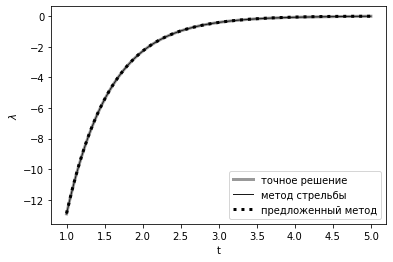

In [ ]:
plt.plot(inputs2, res[:, 1], c='0.6',  linewidth=3)
plt.plot(inputs2, s[:, 1],'-',c='0.1', linewidth=1)
plt.plot(inputs2, res[:, 3],':', c='0.0', linewidth=3)

plt.legend(['точное решение', 'метод стрельбы','предложенный метод'])
plt.gca().set_xlabel('t')
plt.gca().set_ylabel(r'$\lambda$')
#plt.title(r'$\lambda$(t)')
plt.savefig("/content/gdrive/My Drive/ex1_L.eps")
plt.savefig("/content/gdrive/My Drive/ex1_L.png")

In [ ]:
d = numpy.empty(shape=(res.shape[0], 2))
print(d.shape)
for i in range(res.shape[0]):
  d[i, 0] = (res[i, 2] - res[i, 0])
  d[i, 1] = (res[i, 3] - res[i, 1])


(101, 2)


In [ ]:
numpy.abs(d[:, 0]).max()

0.016031402160250216

In [ ]:
numpy.abs(d[:, 1]).max()

0.03321969258527169

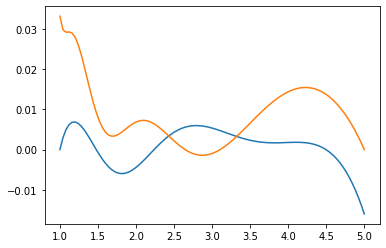

In [ ]:
plt.plot(inputs2, d)

In [ ]:
d0 = numpy.empty(shape=(res.shape[0], 2))
for i in range(res.shape[0]):
  print(res[i, 0])
  d0[i, 0] = (res[i, 2] - res[i, 0]) / res[i, 0]
  d0[i, 1] = (res[i, 3] - res[i, 1]) / res[i, 1]

In [ ]:
numpy.abs(d0[:,0]).max()

0.548050040855283

In [ ]:
numpy.abs(d0[:,1]).max()

1.0

In [ ]:
(res[-1, 3] - res[-1, 1]) / res[-1, 1]

-1.0

In [ ]:
res[-1, 0]

0.02925171245147574

In [ ]:
d[:,1].min()

-1.0

In [ ]:
(res.shape[0], 2)

(101, 2)

In [ ]:
consts['w0'] = bestParams

In [ ]:
def defect(t, c):
    dx, dL = v_dNNdt(c['w0'], t, c)
    x, L = v_nn(c['w0'], t, c)
    u = (x + L)*0.5

    res1 = dx - (x + u)#(dx - (x + u))
    res2 = dL - (-u + 2.*x - L)#(dL - (u - 2.*x + L))
    return res1, res2

In [ ]:
v_nn(consts['w0'], inputs, consts).shape()

NameError: ignored

In [ ]:
def loss2(params, t, c):
    dx, dL = v_dNNdt(params, t, c)
    x, L = v_nn(params, t, c)
    def_x, def_L = defect(t, c)
    u = (x + L)*0.5
    res = 0.
    res += (dx - (x + u + def_x))**2#(dx - (x + u))
    res += (dL - (-u + 2.*x - L + def_L))**2#(dL - (u - 2.*x + L))
    return res.mean()

dLoss2 = grad(loss2, 0)

In [ ]:
epochs = 100000

learning_rate = 0.1
inputs = np.linspace(consts['t0'], consts['t1'], num=51)
batch_size = 10
key = random.PRNGKey(0)
M0 = consts['M0']
M1 = consts['M1']
M2 = consts['M2']
params = (random.normal(key, shape=(M2*M1 + 2*M0 + M0*M1 + M1 + M2 + M2*2 + 2 + M0 + M1 + M2, )))#*0.1
v = 0.0
m = 0.0
b1 = 0.9
b2 = 0.999
bestLoss = 1000000.0
bestParams = params
ec = 1

In [ ]:
bestLoss = 1000000.0

In [ ]:
bad_ep = 0
step = -1e-4
for epoch in range(epochs):
    sample = numpy.random.choice(inputs, size = batch_size)
    rnd = (numpy.random.random(batch_size)-0.5 )*0.1
    #rnd = numpy.clip(rnd, 0., 1.)
    sample += rnd
    sample = numpy.clip(sample, consts['t0'], consts['t1'])
    #assert numpy.array(sample).min() >=0 and numpy.array(sample).max() <= 1.
    #print(sample)
    #learning_rate = learning_rate * 0.999
    learning_rate = learning_rate + step
    if learning_rate <= 1e-8:
     step= 1e-3
    if learning_rate >= 0.1:
      step = -1e-4
    if epoch % ec == 0:
      currLoss = loss2(params, inputs, consts)
      print('epoch: %3d loss: %.6f lr: %.6f', (epoch, currLoss, learning_rate) )
      if currLoss < bestLoss:
        print('Loss Updated!')
        print(' ')
        bestParams = params
        bestLoss = currLoss
      #else:
      #  bad_ep += 1
      #  if bad_ep >= 50:
      #    learning_rate = learning_rate * 0.1
      #    if learning_rate <= 1e-5:
      #      break

       #   bad_ep=0


    gradient = dLoss2(params, sample, consts)# + momentum*velocity
    m = b1*m + (1. -b1)* gradient
    v = b2*v + (1.-b2)*(np.square(gradient))
    m0 = m / (1. -b1)
    v0 = v / (1. -b2)
    velocity = - learning_rate*(m0 / (np.sqrt(v0) + 1e-8))
    params += velocity

Streaming output truncated to the last 5000 lines.
epoch: %3d loss: %.6f lr: %.6f (601, DeviceArray(0.05269049, dtype=float32), 0.03979999999999828)
epoch: %3d loss: %.6f lr: %.6f (602, DeviceArray(0.03789675, dtype=float32), 0.03969999999999828)
epoch: %3d loss: %.6f lr: %.6f (603, DeviceArray(0.02839193, dtype=float32), 0.039599999999998275)
epoch: %3d loss: %.6f lr: %.6f (604, DeviceArray(0.02690125, dtype=float32), 0.03949999999999827)
epoch: %3d loss: %.6f lr: %.6f (605, DeviceArray(0.03340459, dtype=float32), 0.03939999999999827)
epoch: %3d loss: %.6f lr: %.6f (606, DeviceArray(0.03707172, dtype=float32), 0.03929999999999827)
epoch: %3d loss: %.6f lr: %.6f (607, DeviceArray(0.03434018, dtype=float32), 0.039199999999998264)
epoch: %3d loss: %.6f lr: %.6f (608, DeviceArray(0.03142639, dtype=float32), 0.03909999999999826)
epoch: %3d loss: %.6f lr: %.6f (609, DeviceArray(0.02705652, dtype=float32), 0.03899999999999826)
epoch: %3d loss: %.6f lr: %.6f (610, DeviceArray(0.02924222, dtyp

TypeError: ignored

In [ ]:
#with open('/content/gdrive/My Drive/weights1_DEF.npy', 'wb') as f:
#    np.save(f, bestParams)

In [ ]:
w1 = np.load('/content/gdrive/My Drive/weights1.npy', allow_pickle=True)

In [ ]:
w2 = np.load('/content/gdrive/My Drive/weights1_DEF.npy', allow_pickle=True)

In [ ]:
eX = []
eL = []
d0 = []
d1 = []
for t in inputs2:
  eX.append(nn(w2, t, consts)[0] - nn(w1, t, consts)[0])
  eL.append(nn(w2, t, consts)[1] - nn(w1, t, consts)[1])

eX = np.array(eX)
eL = np.array(eL)



In [ ]:
print(numpy.abs(eX).max())
print(numpy.abs(eL).max())

0.017409563
0.020680428


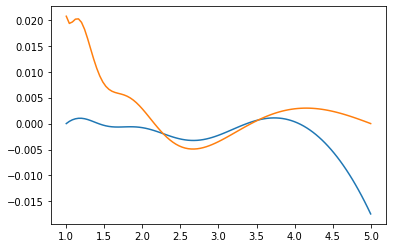

In [ ]:
plt.plot(inputs2, eX)
plt.plot(inputs2, eL)
plt.show()

In [ ]:
eX0 = []
eL0 = []

for t in inputs2:
  s = exact_sol(t)
  sn = nn(w1, t, consts)
  eX0.append(sn[0] - s[0])
  eL0.append(sn[1] - s[1])

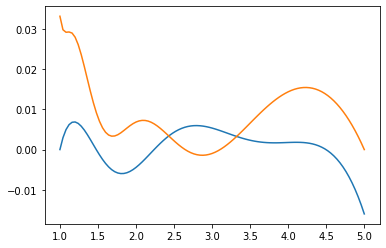

In [ ]:
plt.plot(inputs2, eX0)
plt.plot(inputs2, eL0)
plt.show()

In [ ]:
print(numpy.abs(eX0).max())
print(numpy.abs(eL0).max())

0.016031401
0.033219337


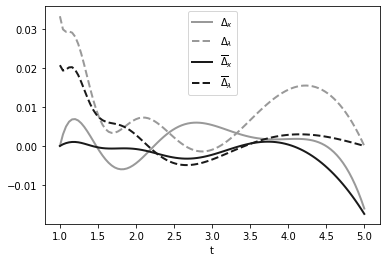

In [ ]:
plt.plot(inputs2, eX0, c='0.6', linewidth=2)
plt.plot(inputs2, eL0,'k--', c='0.6', linewidth=2)
plt.plot(inputs2, eX, c='0.1', linewidth=2)
plt.plot(inputs2, eL,'k--', c='0.1', linewidth=2)
plt.legend([r'$\Delta_x$',r'$\Delta_\lambda$', r'$\overline{\Delta}_x$',r'$\overline{\Delta}_\lambda$'])
plt.gca().set_xlabel('t')
#plt.gca().set_ylabel(r'$\lambda$')
plt.savefig("/content/gdrive/My Drive/ex1_Delta.eps")
plt.savefig("/content/gdrive/My Drive/ex1_Delta.png")
plt.show()

In [ ]:
def fun(t, y, c):
    x, L = y
    u = (x + L)*0.5
    dx = (x + u)#(dx - (x + u))
    dL = (-u + 2.*x - L)
    
    return numpy.array([dx, dL])

In [ ]:
sol = solve_ivp(fun, (consts['t0'], consts['t1']), [1. ,0.], method='RK45', args=(consts,))

In [ ]:
sol.y[1, -1]

(2, 10)

In [ ]:
from scipy.integrate import solve_ivp
from scipy import optimize
def shootin_func(x, c):
    sol = solve_ivp(fun, (c['t0'], c['t1']), [c['ics'][0], x[0]], method='DOP853', args=(c,),atol =1e-8, rtol=1e-8)#DOP853
    if sol.status == -1:
      raise NotImplementedError
      
    return sol.y[1, -1]

In [ ]:
optimize.root(shootin_func, [2.0],method='hybr', args=(consts,),tol=1e-8)

    fjac: array([[-1.]])
     fun: 1.4693662953035869e-12
 message: 'The solution converged.'
    nfev: 5
     qtf: array([-8.07390266e-12])
       r: array([-68.37206473])
  status: 1
 success: True
       x: array([-12.92801797])

In [ ]:
sol = solve_ivp(fun, (consts['t0'], consts['t1']), [2.0, -12.92801797], method='DOP853', args=(consts,), t_eval=inputs,atol =1e-8, rtol=1e-8)